In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

Inorder to get the data from AWS postgres server we can use this command to connect to the server:
>psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic

psql will ask for password and after we provide it we can use following command to select everything from database table and export it to csv file:
>\COPY (select * from train) to '~/Downloads/train.csv' DELIMITER ',' csv header;

Now that we have our csv file we can move it to an appropriate directory and read it through pandas as usual

In [32]:
def load_csv(filename):
    return pd.read_csv(filename)

In [33]:
df=pd.read_csv('train.csv')
df.head(3)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [34]:
df.describe()

,index,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,445.000000,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.500000,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,445.000000,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,667.500000,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,890.000000,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [35]:
# df=titanic_data.copy() # create a copy of data so original dosn't get modified
# df.count()

As we can see not all data is available and we have multiple values missing from `Age`, `Cabin` and `Embarked` columns. I think removing data rows will have negative effect on our classification since we dont know how the real data would look like.

Next step would be feature selection. There are some feature that seem to have effect on survival rate based on survival stories. One of them is gender. As our observation first we are going to show survival rate based on gender.

In [36]:
def survive_total_pivot(data, column):
    piv=pd.pivot_table(data, index=column, values=['index','Survived'], aggfunc=[np.count_nonzero])
    piv.columns=['Survived', 'Total']
    return piv

In [37]:
sex_survive=survive_total_pivot(df, 'Sex')
sex_survive

,Survived,Total
Sex,,
female,233,314
male,109,576


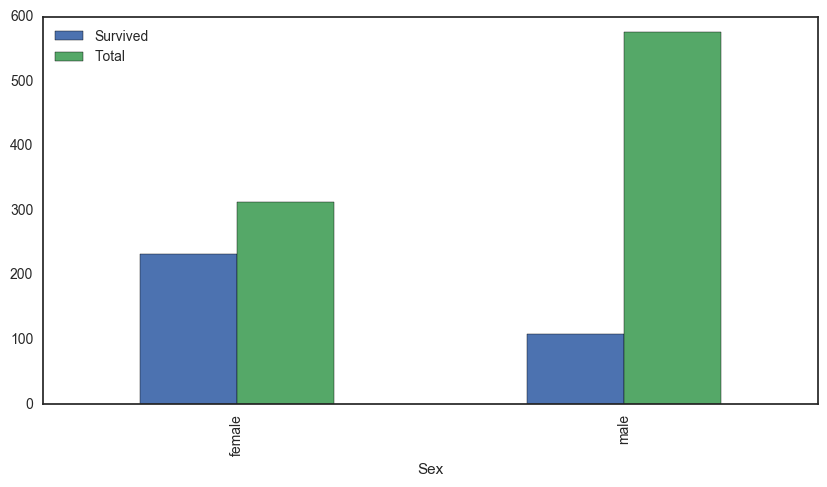

In [38]:
sex_survive.plot(kind='bar', figsize=(10,5))

We can see females had better chanse of survival.

We can also take age to account as a feature. I decided to categorize age so it would be easier to categorize results.

In [39]:
#Binning:
def binning(col, cut_points, labels=None):
    #Define min and max values:
    minval=col.min()
    maxval=col.max()

    #create list by adding min and max to cut_points
    break_points=[minval] + cut_points + [maxval]

    #if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels=range(len(cut_points)+1)

    #Binning using cut function of pandas
    colBin=pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin

In [40]:
tmp = df
tmp["Age_bin"]=binning(df["Age"].fillna(200), 
                        [12, 40, 50, 199], 
                        ['children', 'young', 'middle_age', 'older', 'no_age']
                       )

In [41]:
age_survive=survive_total_pivot(tmp, 'Age_bin')
age_survive

,Survived,Total
Age_bin,,
children,40,69
young,195,494
middle_age,33,86
older,22,64
no_age,52,177


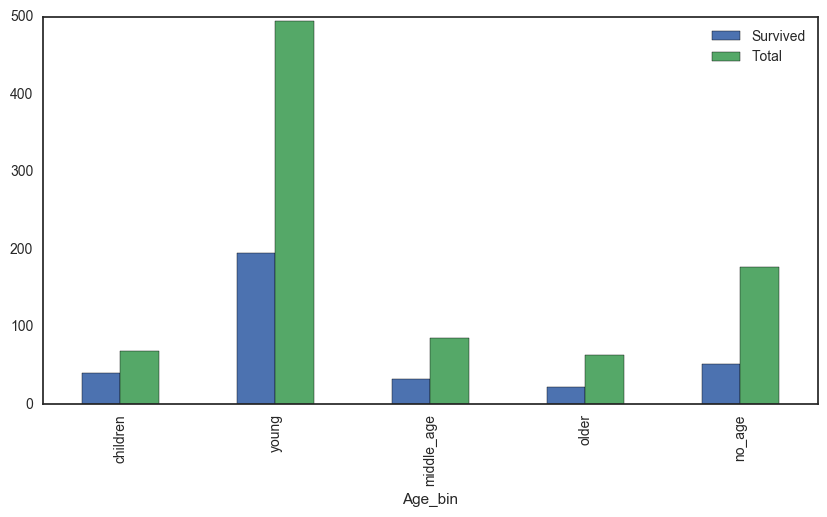

In [42]:
age_survive.plot(kind='bar', figsize=(10,5))

As we can see children had better chance of survival.

Class also may have effect on survival rate.

In [43]:
class_survive=survive_total_pivot(df, 'Pclass')
class_survive

,Survived,Total
Pclass,,
1,136,216
2,87,184
3,119,490


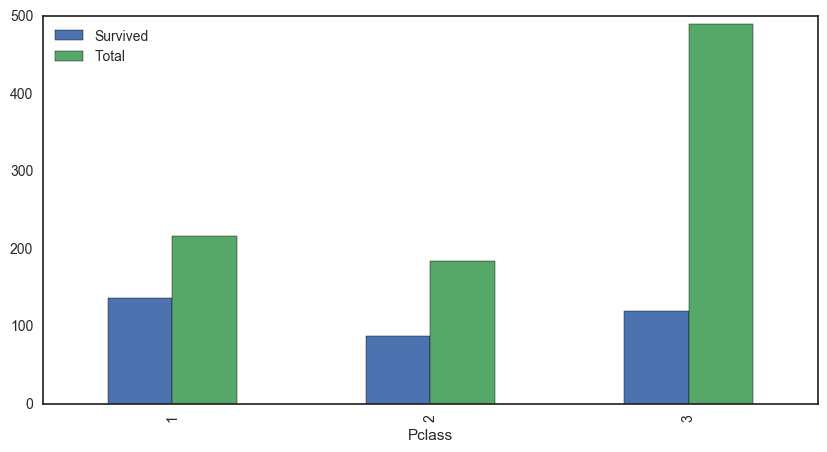

In [44]:
class_survive.plot(kind='bar', figsize=(10,5))

As we can see first class passengers had better chance of survival

Location of the decks could also have effect on survival rate

In [45]:
# tmp=df
tmp['Deck']=df.Cabin.fillna('0').apply(lambda x: x[0] if x!='0' else None).to_frame()
deck_survive=survive_total_pivot(tmp, 'Deck')
deck_survive

,Survived,Total
Deck,,
A,7,15
B,35,47
C,35,59
D,25,33
E,24,32
F,8,13
G,2,4
T,0,1


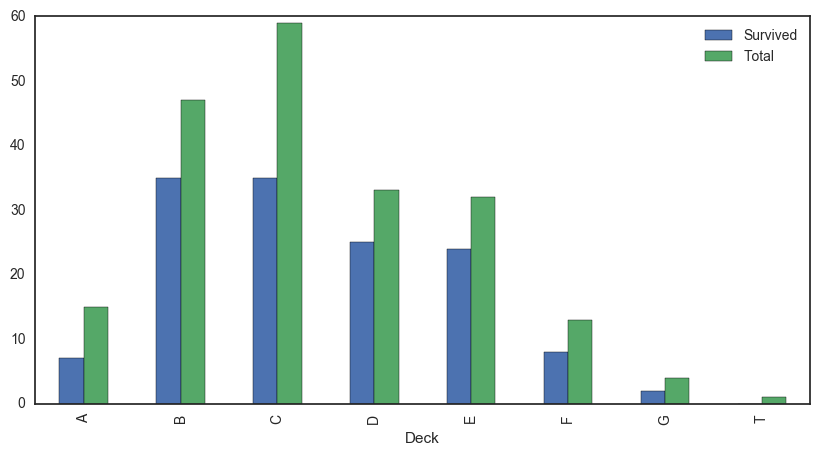

In [46]:
deck_survive.plot(kind='bar', figsize=(10,5))

Although it seems deck can have a significant survival effect but since there are lots of data missing in `Cabin` column we cannot get a good feature.

Now that we have some clue of features we can use in our prediction I decided to use RFE and Kbest feature selectors to find the best selectors. Therefore I'm just going to dummify and extract feature and through them in feature selectors to find the best results

In [47]:
# df.Fare

In [62]:
def get_all_features(data):
    data["Age_bin"]=binning(data["Age"].fillna(200), 
                        [12, 40, 50, 199], 
                        ['children', 'young', 'middle_age', 'older', 'no_age']
                       )
    data['Deck']=data.Cabin.fillna('0').apply(lambda x: x[0] if x!='0' else None).to_frame()
    columns=['Age_bin', 'Pclass', 'Embarked']
    features=[]
    
    for column in columns:
        features.append(pd.get_dummies(data[column], prefix=column))
    
    
    temp=pd.get_dummies(data['Deck'], prefix='Deck')
    if 'Deck_T' not in tmp:
#         print features[-1]
        temp['Deck_T']=0
    
    features.append(temp)
    # Krew of Titanc were also passenger so we can use it as a feature.
    features.append(df.Ticket.apply(lambda x: 1 if x=='LINE' else 0).to_frame())
    features[-1].columns=['Worker']
    # Singles
    features.append(df.apply(lambda x: 1 if (x['SibSp']==0 & x['Parch']==0) else 0, axis=1).to_frame())
    features[-1].columns=['Single']
    # With Family
    features.append(df.apply(lambda x: 1 if (x['SibSp']==1 or x['Parch']==1) else 0, axis=1).to_frame())
    features[-1].columns=['WithFamily']
    features.append(pd.DataFrame(df.Fare, columns=['Fare']))
    return features

In [56]:
# df.Sex.apply(lambda x: 1 if x=='female' else 0).to_frame()

In [57]:
# df.Sex=df.Sex.apply(lambda x: 1 if x=='female' else 0)
# df.head(3)

In [58]:
def combine_features(data, features):
    SS=StandardScaler()
    for feature in features:
        data=data.join(pd.DataFrame(SS.fit_transform(feature), columns=feature.columns), how="left")
    return data

In [59]:
def create_all_features(data, feature_list):
    data.Sex=data.Sex.apply(lambda x: 1 if x=='female' else 0)
    data=data['Sex'].to_frame()
    return combine_features(data, feature_list)

In [60]:
# y=df['Survived']

In [63]:
feature_list=get_all_features(df)
all_features=create_all_features(df, feature_list)

In [64]:
# all_features

# KNN

First I'm going to use KNN as a classifier

In [65]:
# StandardScaler?

In [66]:
def model_score(X, y, model, selector=False):
    if selector:
        X=selector.fit_transform(X,y)
    model.fit(X,y)
    return model.score(X,y)

In [67]:
def best_k_for_kbest(X, y, model):
    max_score=0
    best_k=0
    for i in range(np.count_nonzero(X.columns)):
        score = model_score(X,y,model,SelectKBest(k=i+1))
        if score > max_score:
            max_score=score
            best_k=i+1
    return best_k

In [68]:
knn_kbest_selector=SelectKBest(k=5)
good_features=knn_kbest_selector.fit_transform(all_features, y)
knn=KNeighborsClassifier(n_neighbors=5)
print knn
print model_score(good_features, y, knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.763187429854


/home/ali/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0 19] are constant.
  UserWarning)


Use kbest selector to select 18 (a random number) good features and compare the results

In [69]:
knn_kbest_selector.k=18
good_features=knn_kbest_selector.fit_transform(all_features, y)
print knn
print model_score(good_features, y, knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.767676767677


In [70]:
# pd.DataFrame(good_features)

As we can see results change. Now I'll try useing kbest feature selector to find the best number of features

In [71]:
knn_kbest_selector.k=best_k_for_kbest(all_features, y, knn)
print knn_kbest_selector
good_features=knn_kbest_selector.fit_transform(all_features, y)
print knn
print model_score(good_features, y, knn)

SelectKBest(k=19, score_func=<function f_classif at 0x7f5ec7c65f50>)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.772166105499


Based on all our features if we use 11 of our best features we can have the best results with KNN

Now I'm going to use grid search to optimize my models parameters

In [72]:
def grid_search(model, param_grid):
    return GridSearchCV(estimator=model, 
                        param_grid=param_grid,
                        cv=6
                       )

In [73]:
def knn_params():
    return {'n_neighbors':[1, 3, 5, 7, 9],
            'weights':['uniform', 'distance'],
            'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p':[1, 2]
           }

In [74]:
grid = grid_search(KNeighborsClassifier(), knn_params())
grid.fit(good_features,y)
best_knn_model=grid.best_estimator_
print best_knn_model
print grid.best_score_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=1,
           weights='uniform')
0.707070707071


We can see from above that grid search selected different options for our model which reduces over-fitting

Now I'm going to use cross validation to see if my model produces the best results

In [75]:
x_train, x_test, y_train, y_test=train_test_split(all_features, y)

# ASK RICHARD

In [76]:
# best_knn_model.fit(x_train, y_train)
print model_score(x_train, y_train, best_knn_model)

0.766467065868


In [77]:
train_knn = grid.fit(x_train, y_train).best_estimator_
# train_knn.fit(x_train, y_train)
print model_score(x_train, y_train, train_knn)

0.741017964072


In [78]:
# best_knn_model.fit(x_test, y_test)
print model_score(x_test, y_test, best_knn_model)

0.744394618834


In [79]:
# train_knn.fit(x_test, y_test)
print model_score(x_test, y_test, train_knn)

0.726457399103


### Kaggle

In [80]:
def get_cv(target):
    return StratifiedKFold(target, n_folds=3, shuffle=True, random_state=41)
def score(model, data, target):
    model.fit(data, target)
    return model.score(data, target)
def grid_search(model, params, cv):
    return GridSearchCV(estimator=model, 
                    param_grid=params,
                    cv=cv
                   )
def evaluate_model(model, data, target, params=None):
    x_train, x_test, y_train, y_test=train_test_split(data, target, stratify=target)
#     print score(model, x_train, y_train), "\n"
    cv=get_cv(y_train)
    if params:
        grid=grid_search(model, params, cv)
    
        grid.fit(x_train, y_train)
        model = grid.best_estimator_
        print "Best Model after Grid Search:\n", model
    else:
        model.fit(x_train, y_train)
    s=cross_val_score(model, x_train, y_train, cv=cv, n_jobs=-1)
    print "Mean score of the model is: {}".format(s.mean())
    predictions = model.predict(x_test)
    
    print "Confusion Matrix:\n",confusion_matrix(y_test, predictions), "\n"
    print "Classification Report:\n", classification_report(y_test, predictions)
    return model

# ASK RECHARD

In [86]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split, KFold

def kaggle(model, train_data, train_target,selector=None, params=None, name='kaggle'):
    kaggle_df=pd.read_csv('test.csv')
    kaggl_feature_list=get_all_features(kaggle_df)
    kaggle_all_features=create_all_features(kaggle_df, kaggl_feature_list)
    
#     if 'Deck_T' in train_data:
#         train_data=train_data.drop('Deck_T', 1)
    
    model=evaluate_model(model, train_data, train_target, params)

    if selector:
        kaggle_all_features=selector.transform(kaggle_all_features)
    
    kaggle_results=model.predict(kaggle_all_features)
    print kaggle_results
    kaggle_results=pd.DataFrame(kaggle_results)
    kaggle_results=kaggle_df.PassengerId.to_frame().join(kaggle_results)
    kaggle_results=kaggle_results[['PassengerId', 0]]
    kaggle_results.columns=['PassengerId', 'Survived']
    kaggle_results.to_csv(name+'.csv', index=False)

In [87]:
kaggle(best_knn_model, pd.DataFrame(good_features), y, 
       selector=knn_kbest_selector,name='kaggle_knn')

Mean score of the model is: 0.673664736165
Confusion Matrix:
[[100  37]
 [ 36  50]] 

Classification Report:
             precision    recall  f1-score   support

          0       0.74      0.73      0.73       137
          1       0.57      0.58      0.58        86

avg / total       0.67      0.67      0.67       223

[0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0
 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1
 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1
 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0
 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1
 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0
 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0
 

# ExtraTreesClassifier

In [ ]:
params={
    'n_estimators': [10, 20, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth':[1, 10, 50, 100, 500],
    'min_samples_split': [2, 5, 10, 20],
}

In [ ]:
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)
kaggle(et, all_features, y, params, name='kaggle_ExtraTrees')

As we can see our model was able to categorize the test data with 2% error which is decent.

We can see confusion matrix, Precision/Recall matrix and its heatmap as follow:

In [ ]:
def show_prediction_results(model, data, target, test):
    

In [ ]:
show_prediction_results(best_knn_model, good_features,y, x_test)

In [ ]:
# good_features=kbest_selector.fit_transform(all_features, y)
best_knn_model.fit(good_features,y)
predictions=best_knn_model.predict(good_features)
print "Confusion matrix: \n", confusion_matrix(y, predictions)
print "\nPrecision Recall:\n", classification_report(y, predictions)
sns.heatmap(confusion_matrix(y, predictions), annot=True)

We can also plot ROC curve of our model

In [ ]:
y_pred=grid.best_estimator_.predict(SS.fit_transform(good_features))
FPR=dict()
TPR=dict()
ROC_AUC=dict()
print roc_curve(y, y_pred)
FPR[1], TPR[1], _=roc_curve(y, y_pred)
ROC_AUC[1]=auc(FPR[1], TPR[1])
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area=%0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC for titanic survival with KNN', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Logistic Regression

Now I'm going to use Logistic Regression as categorizer. This time I'm going to use both Kbest and RFE to find the best features

In [ ]:
def best_k_for_rfe(X,y,model):
    max_score=0
    best_k=0
    for i in range(np.count_nonzero(X.columns)):
        selector=RFE(estimator=model, step=1, n_features_to_select=i+1)
        score = model_score(X,y,model,selector)
#         model.fit(rfe.fit_transform(X, y), y)
#         score=model.score(rfe.fit_transform(X, y), y)
        
        if score > max_score:
            max_score=score
            best_k=i+1
    return best_k

def best_log_rfe_k(X,y,model, max_features, n=5):
    max_score=0
    best_k=0
    for i in range(max_features):
        rfe=RFE(estimator=model, step=1, n_features_to_select=i+1)
        model.fit(rfe.fit_transform(X, y), y)
        score=model.score(rfe.fit_transform(X, y), y)
        
        if score > max_score:
            max_score=score
            best_k=i+1
    return best_k

In [ ]:
def best_log_kbest_k(X,y,model,max_features, n=5):
    max_score=0
    best_k=0
    for i in range(max_features):
        kbest=SelectKBest(k=i+1)
        model.fit(kbest.fit_transform(X, y), y)
        score=model.score(kbest.fit_transform(X, y), y)
        if score > max_score:
            max_score=score
            best_k=i+1
    return best_k

## RFE

In [ ]:
model=LogisticRegression()
rfe_k=best_log_rfe_k(all_features, y, model, feature_count)
print "best number of features in RFE feature selector: ", rfe_k
rfe_log_selector=RFE(estimator=model, step=1, n_features_to_select=rfe_k)
best_rfe_features=rfe_log_selector.fit_transform(all_features, y)
model.fit(best_rfe_features, y)
print model.score(rfe_log_selector.fit_transform(all_features, y), y)

As we can see `13` is the best number of features and RFE selects them for us

Now we try to improve our selector

We can have different parametrs in our model:

In [ ]:
model=LogisticRegression(penalty='l1', C=0.1)
print model.fit(best_rfe_features,y)
print model.coef_
print model.score(best_rfe_features,y)

In [ ]:
model=LogisticRegression(penalty='l1', C=1)
print model.fit(best_rfe_features,y)
print model.coef_
print model.score(best_rfe_features,y)

In [ ]:
model=LogisticRegression(penalty='l2', C=1)
print model.fit(best_rfe_features,y)
print model.coef_
print model.score(best_rfe_features,y)

In [ ]:
model=LogisticRegression()
Cs=[.01, .03, .05, 0.7, .09, .1, .3, .5, .7, 1, 10, 50, 100]
Ls=['l1', 'l2']
rfe_grid=GridSearchCV(estimator=model, 
                    param_grid={'C': Cs,
                                'penalty': Ls
                               },
                    cv=6
                   )
rfe_grid.fit(best_rfe_features,y)
print rfe_grid.best_estimator_
print rfe_grid.best_score_
log_model_rfe=rfe_grid.best_estimator_
predictions=log_model_rfe.predict(best_rfe_features)
print "\nConfusion Matrix:\n", confusion_matrix(y, predictions)
print "\nPrecision Recall:\n", classification_report(y, predictions)
sns.heatmap(confusion_matrix(y, predictions), annot=True)

Now we are going to cross validate to determine wether our model over-fits or not

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(all_features, y)
x_train.shape, x_test.shape

In [ ]:
train_rfe=rfe_log_selector.fit_transform(x_train, y_train)
print train_rfe.shape
train_rfe

In [ ]:
log_model_rfe.fit(train_rfe, y_train)
print 'Score with training data (rfe):', log_model_rfe.score(train_rfe, y_train)

In [ ]:
test_rfe=rfe_log_selector.transform(x_test)
print 'Score with TEST data (rfe):', log_model_rfe.score(test_rfe, y_test)

In [ ]:
log_model_rfe.fit(x_train, y_train)
print 'Score with training data (all):', log_model_rfe.score(x_train, y_train)

In [ ]:
print 'With all of our columns! We get:', log_model_rfe.score(x_test, y_test)

This shows our model has low over-fitting

In [ ]:
scores=rfe_log_selector.ranking_

predictors=all_features.columns

print scores
print rfe_log_selector.support_
for item in zip(predictors, scores, rfe_log_selector.support_):
    print item


# # Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()


In [ ]:
y_pred=log_model_rfe.decision_function(x_test)
FPR=dict()
TPR=dict()
ROC_AUC=dict()
print roc_curve(y_test, y_pred)
FPR[1], TPR[1], _=roc_curve(y_test, y_pred)
ROC_AUC[1]=auc(FPR[1], TPR[1])
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area=%0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC for titanic survival with RFE', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Kbest

Now we are going to do the same for Kbest feature selector

In [ ]:
def best_log_kbest_k(X,y,model,max_features, n=5):
    max_score=0
    best_k=0
    for i in range(max_features):
        kbest=SelectKBest(k=i+1)
        model.fit(kbest.fit_transform(X, y), y)
        score=model.score(kbest.fit_transform(X, y), y)
        if score > max_score:
            max_score=score
            best_k=i+1
    return best_k

In [ ]:
kbest_log_model=LogisticRegression()
kbest_k=best_log_kbest_k(all_features, y, kbest_log_model, feature_count)
print "best number of features in Kbest feature selector: ", kbest_k
kbest_log_selector=SelectKBest(k=kbest_k)
best_kbest_features=kbest_log_selector.fit_transform(all_features, y)
kbest_log_model.fit(best_kbest_features, y)
print kbest_log_model.score(kbest_log_selector.fit_transform(all_features, y), y)

For Kbest in this model it is better to use `23` features which is all of our features

Since we are using all 23 features results will be the same as all_features and because of that I'm going to use 18 as K so our resuls may vary and compare it to all_features

In [ ]:
kbest_log_selector=SelectKBest(k=18)
best_kbest_features=kbest_log_selector.fit_transform(all_features, y)
kbest_log_model.fit(best_kbest_features, y)
print kbest_log_model.score(kbest_log_selector.fit_transform(all_features, y), y)

In [ ]:
model=LogisticRegression(penalty='l1', C=0.1)
print model.fit(best_kbest_features,y)
print model.coef_
print model.score(best_kbest_features,y)

In [ ]:
model=LogisticRegression(penalty='l1', C=10)
print model.fit(best_kbest_features,y)
print model.coef_
print model.score(best_kbest_features,y)

So to tweak things further i'm going to use grid search to find the best parameters

In [ ]:
model=LogisticRegression()
Cs=[.01, .03, .05, 0.7, .09, .1, .3, .5, .7, 1, 10, 50, 100]
Ls=['l1', 'l2']
kbes_grid=GridSearchCV(estimator=model, 
                    param_grid={'C': Cs,
                                'penalty': Ls
                               },
                    cv=6
                   )
kbes_grid.fit(best_kbest_features,y)
print kbes_grid.best_estimator_
print kbes_grid.best_score_
log_model_kbest=kbes_grid.best_estimator_
predictions=log_model_kbest.predict(best_kbest_features)
print "\nConfusion Matrix:\n", confusion_matrix(y, predictions)
print "\nPrecision Recall:\n", classification_report(y, predictions)
sns.heatmap(confusion_matrix(y, predictions), annot=True)

To crossvalidate again I'm going to split data set to test and train

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(all_features, y)
x_train.shape, x_test.shape

In [ ]:
train_kbest=kbest_log_selector.fit_transform(x_train, y_train)
print train_kbest.shape
train_kbest

In [ ]:
log_model_kbest.fit(train_kbest, y_train)
print 'Score with training data (kbest):', log_model_kbest.score(train_kbest, y_train)

In [ ]:
test_kbest=kbest_log_selector.fit_transform(x_test, y_test)
print 'Score with TEST data (kbest):', log_model_kbest.score(test_kbest, y_test)

In [ ]:
log_model_kbest.fit(x_train, y_train)
print 'Score with training data (all):', log_model_kbest.score(x_train, y_train)

In [ ]:
print 'With all of our columns! We get:', log_model_kbest.score(x_test, y_test)

As we can see we have more over-fitting than RFE

In [ ]:
scores=-np.log10(kbest_log_selector.pvalues_)
print scores
print kbest_log_selector.pvalues_

predictors=all_features.columns

# # Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()


In [ ]:
y_pred=log_model_kbest.decision_function(x_test)

FPR=dict()
TPR=dict()
ROC_AUC=dict()

print roc_curve(y_test, y_pred)

FPR[1], TPR[1], _=roc_curve(y_test, y_pred)
ROC_AUC[1]=auc(FPR[1], TPR[1])


plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area=%0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()
